In [6]:
import torch
from torch_geometric.utils import add_self_loops
import torch.nn.functional as F

In [7]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)
        # 이걸하면 message랑 aggregate가 내부적으로 돌아가도록 되어있다.
        # 물론 aggregator는 그냥저냥 정의된대로 연산만 하면되는 거라서 아래 def message의 인풋과 적절하게 연결된 상태로정의만 되면 된다


        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

잠깐만... add_self_loops가 뭘하는건지 모르겠어서 한번 찍어봤다.

```
add_self_loops
(edge_index: Tensor, edge_attr: Optional[Tensor] = None,
fill_value: Optional[Union[float, Tensor, str]] = None,
 num_nodes: Optional[Union[int, Tuple[int, int]]] = None)→ Tuple[Tensor, Optional[Tensor]][source]
```
Adds a self-loop $(i,i)$ to every node $i \in \mathcal{V}$ in the graph given by edge_index.
In case the graph is weighted or has multi-dimensional edge features `(edge_attr != None)`, edge features of self-loops will be added according to fill_value.

PARAMETERS

- edge_index (LongTensor) – The edge indices.
- edge_attr (Tensor, optional) – Edge weights or multi-dimensional edge features. (default: None)
- fill_value (float or Tensor or str, optional) – The way to generate edge features of self-loops (in case edge_attr != None). If given as float or torch.Tensor, edge features of self-loops will be directly given by fill_value. If given as str, edge features of self-loops are computed by aggregating all features of edges that point to the specific node, according to a reduce operation. ("add", "mean", "min", "max", "mul"). (default: 1.)
- num_nodes (int or Tuple[int, int], optional) – The number of nodes, i.e. max_val + 1 of edge_index. If given as a tuple, then edge_index is interpreted as a bipartite graph with shape (num_src_nodes, num_dst_nodes). (default: None)

RETURN TYPE
`(LongTensor, Tensor)`

In [8]:
edge_index = torch.tensor([[0, 1, 0],
...                        [1, 0, 0]])
edge_weight = torch.tensor([0.5, 0.5, 0.5])

print(add_self_loops(edge_index))


(tensor([[0, 1, 0, 0, 1],
        [1, 0, 0, 0, 1]]), None)


즉 원래는 지들끼리 연결된거에 대한 정보가 생략된 녀석들도 있고, 아예 없는 녀석들도 있는데, 업데이트를 위해서는 self_loop이 필요하니까 그걸 더해주겠다는 뜻.

오케이. 그럼 이제 실제로 GCNConv를 implement해보자.

대충 아래처럼 하면 레이어 하나에 대한 연산이 될거로 생각할 수 있다



load data

In [11]:
from torch_geometric.datasets import Planetoid

In [12]:
dataset = Planetoid(root="tutorial1",name= "Cora")

In [35]:
class GNN(torch.nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.conv1 = GCNConv(n_features, n_features)
        self.conv2 = GCNConv(n_features, n_features)
        self.linear = Linear(n_features, n_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.linear(x)
        return F.log_softmax(x, dim=1)


In [36]:
data = dataset[0].to('cpu') # 구조상 이렇게 가져와야하는 그래프
# 모델 가져오고
model=GNN(dataset.num_features, dataset.num_classes).to('cpu')
optimizer=torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


In [37]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [47]:
def train():
    model.train()
    optimizer.zero_grad()
    F.nll_loss(model(x=data.x, edge_index=data.edge_index)[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()


def test():
    model.eval()
    logits, accs = model(x=data.x, edge_index=data.edge_index), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [48]:
best_val_acc = test_acc = 0
for epoch in range(1,100):
    train()
    _, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Val: {:.4f}, Test: {:.4f}'

    if epoch % 10 == 0:
        print(log.format(epoch, best_val_acc, test_acc))

Epoch: 010, Val: 0.7780, Test: 0.7870
Epoch: 020, Val: 0.7780, Test: 0.7870
Epoch: 030, Val: 0.7800, Test: 0.8010
Epoch: 040, Val: 0.7840, Test: 0.8010
Epoch: 050, Val: 0.7920, Test: 0.8080
Epoch: 060, Val: 0.7920, Test: 0.8080
Epoch: 070, Val: 0.7920, Test: 0.8080
Epoch: 080, Val: 0.7920, Test: 0.8080
Epoch: 090, Val: 0.7920, Test: 0.8080


## 실제로 더 간단하게 해봅시다

저도 이게 layer 연산 한번 하는게 어떻게 되는건지 확실히 알지를 못하겠어서

그럼 아래와 같이 구성된다.

In [52]:
import networkx as nx
from torch_geometric.utils.convert import from_networkx

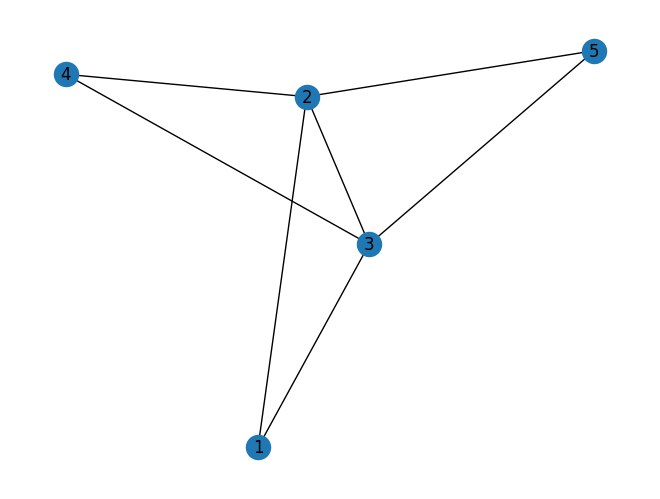

In [97]:
# Make the networkx graph
G = nx.Graph()
# Add some cars (just do 4 for now)
G.add_nodes_from([
      (1, {'y': 1, 'x': [0.5]}),
      (2, {'y': 2, 'x': [0]}),
      (3, {'y': 3, 'x': [0]}),
      (4, {'y': 4, 'x': [0.5]}),
      (5, {'y': 5, 'x': [0]})
])
# Add some edges
G.add_edges_from([(1,2),(2,1),(1,3),(3,1),(2,3),(3,2),(2,4),(4,2),(3,4),(4,3), (5,2), (2,5), (5,3), (3,5)])
nx.draw(G, with_labels=True)



In [98]:
# Convert the graph into PyTorch geometric
pyg_graph = from_networkx(G)

print(pyg_graph)
# Data(edge_index=[2, 12], x=[5], y=[5])
print(pyg_graph.x)
# tensor([0.5000, 0.2000, 0.3000, 0.1000, 0.2000])
print(pyg_graph.y)
# tensor([1, 2, 3, 4, 5])
print(pyg_graph.edge_index)
# tensor([[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 4, 4],
#         [1, 3, 4, 0, 2, 3, 1, 4, 0, 1, 0, 2]])


Data(x=[5, 1], edge_index=[2, 14], y=[5])
tensor([[0.5000],
        [0.0000],
        [0.0000],
        [0.5000],
        [0.0000]])
tensor([1, 2, 3, 4, 5])
tensor([[0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4],
        [1, 2, 0, 2, 3, 4, 0, 1, 3, 4, 1, 2, 1, 2]])


In [99]:
pyg_graph.x

tensor([[0.5000],
        [0.0000],
        [0.0000],
        [0.5000],
        [0.0000]])

In [100]:
pyg_graph_1 =GCNConv(pyg_graph.num_features, pyg_graph.num_features)(pyg_graph.x, pyg_graph.edge_index)

In [101]:
print(pyg_graph_1)

tensor([[0.0209],
        [0.0324],
        [0.0324],
        [0.0209],
        [0.0000]], grad_fn=<AddBackward0>)


In [102]:
pyg_graph_2 =GCNConv(pyg_graph.num_features, pyg_graph.num_features)(pyg_graph_1, pyg_graph.edge_index)

In [103]:
print(pyg_graph_2)

tensor([[0.0144],
        [0.0144],
        [0.0144],
        [0.0144],
        [0.0101]], grad_fn=<AddBackward0>)


여기 보면 이제야 5번에 어떤 값이 들어온다. 왜? depth=2 가 되었기 때문에 드디어 0이 아닌 정보들이 들어왔기 때문에.

*그렇다면 이게 local 정보만 업데이트하는 방식을로도 쓰일 수 있을까?*

In [109]:
edge_partial = torch.Tensor([[1,2,4,4],[4,4,1,2]])
# and make edge_partial as int16
edge_partial = edge_partial.type(torch.int16)
print(edge_partial)

tensor([[1, 2, 4, 4],
        [4, 4, 1, 2]], dtype=torch.int16)


In [110]:
pyg_graph_1 =GCNConv(pyg_graph.num_features, pyg_graph.num_features)(pyg_graph.x, edge_partial)

In [111]:
print(pyg_graph_1)

tensor([[-0.4969],
        [ 0.0000],
        [ 0.0000],
        [-0.4969],
        [ 0.0000]], grad_fn=<AddBackward0>)


In [115]:
pyg_graph_2 =GCNConv(pyg_graph.num_features, pyg_graph.num_features)(pyg_graph_1, edge_partial)

In [116]:
print(pyg_graph_2)

tensor([[0.2976],
        [0.0000],
        [0.0000],
        [0.2976],
        [0.0000]], grad_fn=<AddBackward0>)


In [118]:
pyg_graph_3 =GCNConv(pyg_graph.num_features, pyg_graph.num_features)(pyg_graph_2, pyg_graph.edge_index)

In [119]:
print(pyg_graph_3)

tensor([[0.0709],
        [0.1098],
        [0.1098],
        [0.0709],
        [0.0000]], grad_fn=<AddBackward0>)


이런식으로 하면 업데이트가 안되는 것을 볼 수 있습니다~